In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import torch
import matplotlib.pyplot as plt
import gip_bnn

In [42]:
plt.style.use('ggplot')

### Dataset stuff here:

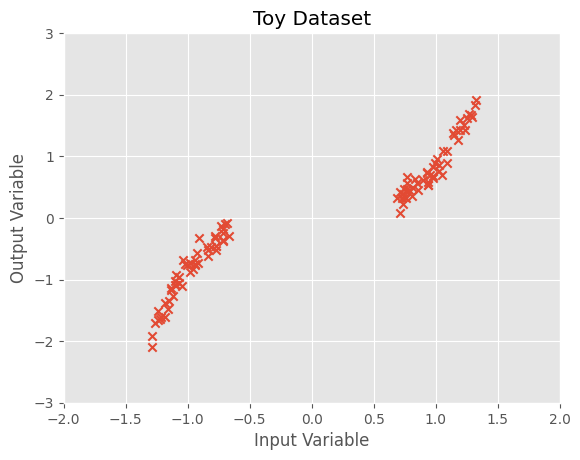

In [43]:
noise_std = torch.tensor(4.0)
dataset_size = 100

x_neg, x_pos = torch.zeros(dataset_size//2), torch.zeros(dataset_size//2)
x_neg, x_pos = x_neg.uniform_(-4, -2), x_pos.uniform_(2, 4)
x = torch.cat((x_neg, x_pos))

y = x**3 + noise_std * torch.normal(torch.zeros(dataset_size), torch.ones(dataset_size))

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

plt.scatter(x, y, marker='x')
plt.title('Toy Dataset')
plt.xlabel('Input Variable')
plt.ylabel('Output Variable')
plt.xlim(-2, 2)
plt.ylim(-3, 3)
plt.show()

### Do some experiments

In [58]:
num_induce = 50
inducing_points = x[torch.randperm(dataset_size)[:num_induce]].unsqueeze(1)

gip_model = gip_bnn.GINetwork(1, [50, 50], 1, inducing_points)
print(gip_model)

opt = torch.optim.Adam(
    gip_model.parameters(),
    lr = 0.01
)

GINetwork(
  (nonlinearity): ELU(alpha=1.0)
  (network): ModuleList(
    (0): GILayer(
      (nonlinearity): ELU(alpha=1.0)
    )
    (1): GILayer(
      (nonlinearity): ELU(alpha=1.0)
    )
    (2): GILayer(
      (nonlinearity): ELU(alpha=1.0)
    )
  )
)


In [59]:
loss_evo = []
ll_evo = []
kl_evo = []

for epoch in range(1, 1501):  # epochs
    if epoch % 300 == 0:
        print('epoch: ', epoch)
    opt.zero_grad()

    elbo, ll, kl, noise = gip_model.elbo_loss(x.unsqueeze(1), y.unsqueeze(1), num_samples=4)
    loss_evo.append(elbo.item())
    ll_evo.append(ll.item())
    kl_evo.append(kl.item())

    elbo.backward()
    opt.step()

epoch:  300
epoch:  600
epoch:  900
epoch:  1200
epoch:  1500


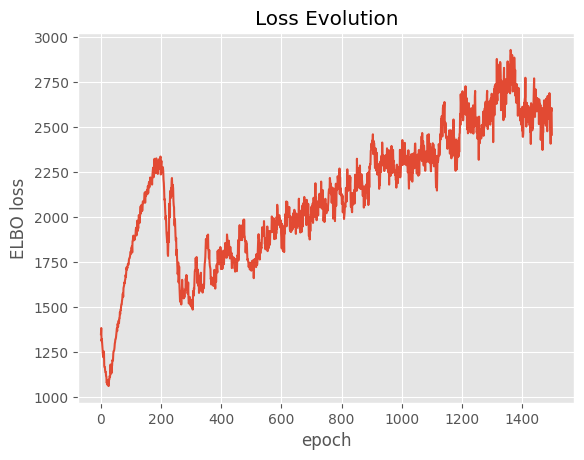

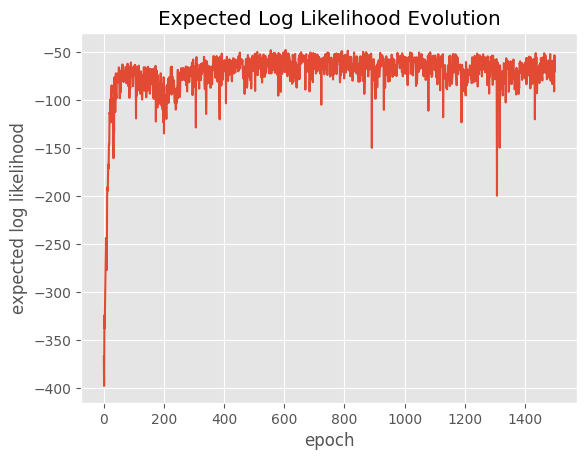

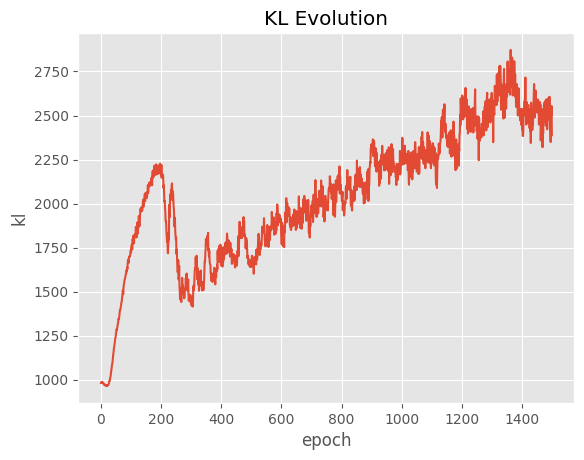

In [60]:
plt.plot(loss_evo)
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.title('Loss Evolution')
plt.show()

plt.plot(ll_evo)
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(kl_evo)
plt.ylabel('kl')
plt.xlabel('epoch')
plt.title('KL Evolution')
plt.show()

In [61]:
xs = torch.linspace(-2, 2, 200).unsqueeze(1)
prediction_samps = gip_model(xs, num_samples=100)[0].squeeze(-1).T

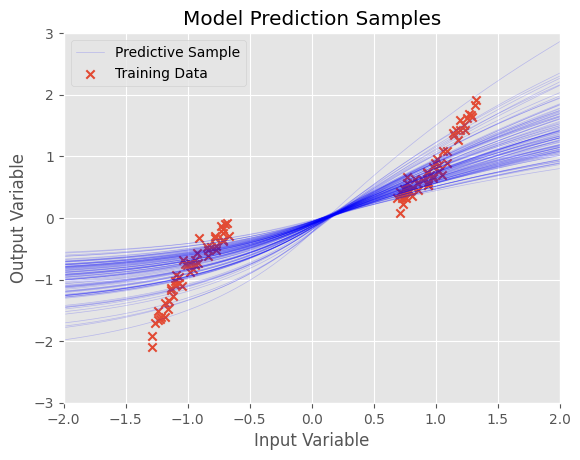

In [62]:
plt.plot(xs.detach().numpy(), prediction_samps.detach().numpy()[:,:-1], color='blue', linewidth=0.5, alpha = 0.2)
plt.plot(xs.detach().numpy(), prediction_samps.detach().numpy()[:,-1], color='blue', linewidth=0.5, alpha = 0.2, label='Predictive Sample')
plt.title('Model Prediction Samples')
plt.xlabel('Input Variable')
plt.ylabel('Output Variable')
plt.scatter(x, y, marker='x', label='Training Data')
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-3, 3)
plt.show()